# Testing LDMNet over Cifar 10 using Inception features - with hyper-parameter search
In this notebook, we run a classification experiment based on Inception features extracted from the Cifar 10 dataset. 
A script doing hyper-parameter search was executed. 100 parameter sets were tested. 
Early stopping is used after 20 non-improving epochs (measured over validation loss).
Experiment is repeated for multiple training set sizes.

In [14]:
from Cifar10InceptionV3ClusterAndClassify import gen_cifar10, spliters
import numpy as np
import matplotlib.pyplot as plt

from skorch_utils import MLP, LRScheduler, SaveWeights, EarlyStopping, NaNStopping
from LDMM import LDMNetSkorch, SaveLDMNetVars

import torch
import os
import pandas as pd

from sklearn.model_selection import RandomizedSearchCV, StratifiedShuffleSplit
from scipy.stats import uniform, randint, reciprocal
    
random_state=0
np.random.seed(random_state)
skf, skf_cv = spliters(random_state, train_size=200, cv_repeats=5)

/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1635: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [15]:
X_imgs, X, y = gen_cifar10(plot=False)
X = X.astype(np.float32)
y = y.astype(np.int64)

In [16]:
X.shape, y.shape, X_imgs.shape

((60000, 2048), (60000,), (60000, 32, 32, 3))

In [17]:
n_hparams = 100
max_epochs = 600

BASE_DIR = 'Cifar10LDMNetHparams/%d_hparams_%d_max_epochs_train_size_%d/'
FILE = 'save.pkl'

saves = []
for train_size in [500]:
    DIR = BASE_DIR % (n_hparams, max_epochs, train_size)
    os.makedirs(DIR, exist_ok=True)
    fname = os.path.join(DIR, FILE)
    saved = pd.read_pickle(fname)
    saves.append(saved)

In [18]:
for saved in saves:
    train, test = saved['split']
    search = saved['search']
    model = search.best_estimator_
    print("best params ", search.best_params_)
    print("test accuracy @ ", train.size, ": ",model.score(X[test],y[test]))

best params  {'lambda_bar': 9.546689170495839, 'mu': 0.4146719399905236, 'lr': 0.0062184832175007166}
test accuracy @  500 :  0.6947


In [20]:
results = pd.DataFrame(search.cv_results_)
df=pd.DataFrame(results, columns=['param_lambda_bar', 'param_lr', 'param_mu'])

/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


<IPython.core.display.Javascript object>


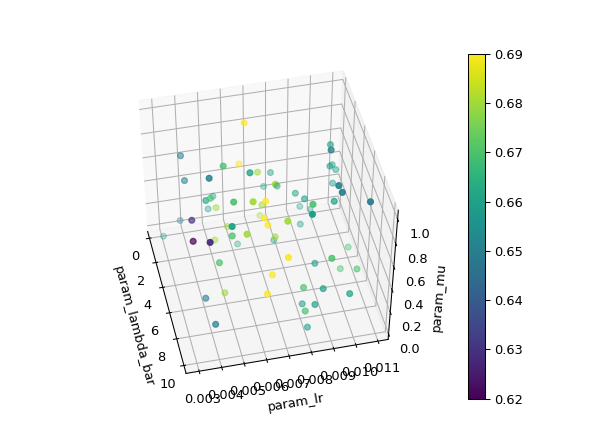

In [32]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
mask = results.mean_test_score.values > 0.6
p = ax.scatter(*df.values[mask].T, c=results.mean_test_score.values[mask], cmap='viridis')
set_labels = lambda x, y, z: (ax.set_xlabel(x), ax.set_ylabel(y), ax.set_zlabel(z))
set_labels(*df.columns.values)
plt.colorbar(p)

In [25]:
%run LDMM_plot_utils.py

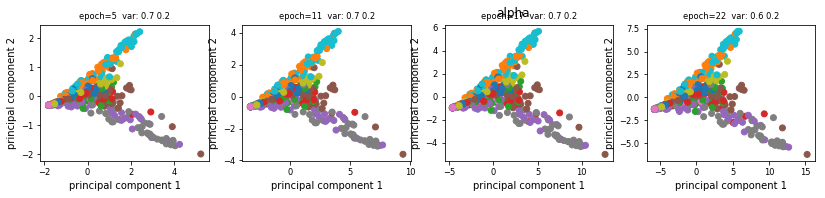

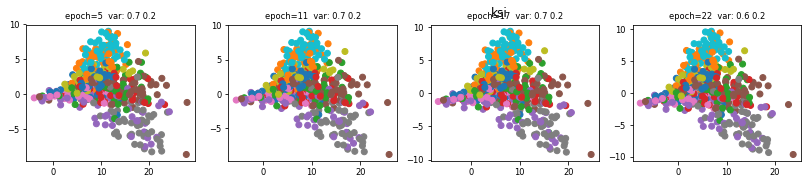

In [26]:
plot_ksi_alpha_time(model, every_n=1, y=y[train], cmap='tab10')

In [27]:
early_stop = dict(model.callbacks_)['EarlyStopping']


In [28]:
early_stop.critical_epoch_, early_stop.non_improvement_

(1, 21)